## BERT Fine-tuned 'average_word_embeddings_glove.6B.300d'

In [1]:
# Importando bibliotecas e funções
from libs import *
from utils import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\domaf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


BERT, ou Bidirectional Encoder Representations from Transformers, é um modelo de linguagem pré-treinado que foi introduzido em 2018 pelo Google. Ele é baseado em um modelo de transformador, que é um tipo de rede neural que pode aprender relações entre palavras em uma frase, em vez de apenas uma por uma em ordem.

O BERT pode ser usado para uma variedade de tarefas de processamento de linguagem natural (NLP), inclusive para gerar embeddings contextualizadas, que são representações de palavras que levam em consideração o contexto em que a palavra é usada. Isso pode ser útil para uma variedade de tarefas de NLP, pois pode ajudar o modelo a entender o significado de palavras em diferentes contextos.

Neste projeto, realizamos o experimento de avaliar o impacto da utilização do BERT ao alimentar nosso modelo de classificação com features textuais (títulos e descrições dos vídeos) e verificar os respectivos resultados. O modelo base da biblioteca `transformers` está disponível no Hugging Face Hub.

**SentenceTransformers** é um framework estado da arte em Python para embeddings de sentenças, texto e imagens. Ele usa modelos de linguagem pré-treinados para transformar texto em vetores significativos, chamados de embeddings. Essas representações contextualizados podem ser aplicadas em tarefas de processamento de linguagem natural de maneira eficiente. A sua utilização é trivial e mais simples ao comparar com outras bibliotecas e por isso foi escolhida para esse projeto.

- Hugging Face:  https://huggingface.co/sentence-transformers
- Documentação: https://www.sbert.net/
- Artigo: https://arxiv.org/abs/1908.10084

1. Instalando a biblioteca `sentence-transformers`

In [2]:
# Instalando framework via pip
#!pip install -U sentence-transformers

2. Importando bibliotecas necessárias para tarefa de gerar representações textuais (embeddings)

In [3]:
# Sentence-transformers
from sentence_transformers import SentenceTransformer

3. Carregando base de dados em um DataFrame do Pandas

In [4]:
# Definindo dataframe preprocessado antes dos pipelines
df_bert = pd.read_csv('data/data1.csv') # data1 (texto bruto) ou data2 ou data3 (texto preprocessado)

In [5]:
# Amostra de 10%
#df_bert = df_bert.sample(frac=0.1, random_state=42) 

In [6]:
# Dimensões
df_bert.shape

(36642, 18)

In [7]:
# Definindo colunas numéricas, categóricas e textuais
numeric_features = ['year', 'video_count', 'view_count_x', 'subscriber_count', 
                    'aux_status', 'comment_count_y','dislike_count', 'view_count_y',
                        'like_count', 'video_duration', 'published_at']

categorical_features = ['channel_id','category', 'gender']

textual_features = ['video_title', 'video_desc']

In [8]:
# Substituindo valores nulos por uma string vazia
df_bert[textual_features] = df_bert[textual_features].fillna('')

4. Divisão dos dados em treino e teste, de maneira a evitar vazamento de dados (data leakage)


In [9]:
# Definindo características e alvo
#X = df_bert[textual_features + categorical_features]
X = df_bert[textual_features]
y = df_bert['popularity']

X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
"""
# Aplicando OneHotEncoder nas colunas categóricas com handle_unknown='ignore'
encoder = OneHotEncoder(handle_unknown='ignore')

X_train_bert_categorical = encoder.fit_transform(X_train_bert[categorical_features])
X_test_bert_categorical = encoder.transform(X_test_bert[categorical_features])

# 3 features categóricas representadas em matriz esparsa
print(X_train_bert_categorical[0])

# 3 features categóricas representadas em matriz densa
print(X_train_bert_categorical.toarray()[0])

# Transformando as features categóricas em matriz densa (array) para combinar com outras features no futuro
X_train_bert_categorical = X_train_bert_categorical.toarray()
X_test_bert_categorical = X_test_bert_categorical.toarray()
"""

"\n# Aplicando OneHotEncoder nas colunas categóricas com handle_unknown='ignore'\nencoder = OneHotEncoder(handle_unknown='ignore')\n\nX_train_bert_categorical = encoder.fit_transform(X_train_bert[categorical_features])\nX_test_bert_categorical = encoder.transform(X_test_bert[categorical_features])\n\n# 3 features categóricas representadas em matriz esparsa\nprint(X_train_bert_categorical[0])\n\n# 3 features categóricas representadas em matriz densa\nprint(X_train_bert_categorical.toarray()[0])\n\n# Transformando as features categóricas em matriz densa (array) para combinar com outras features no futuro\nX_train_bert_categorical = X_train_bert_categorical.toarray()\nX_test_bert_categorical = X_test_bert_categorical.toarray()\n"

5. Carregando modelo BERT através do framework estado da arte Sentence-Transformers para a criação de representações textuais.

- Modelos nativamente disponíveis: [Pretrained Models](https://www.sbert.net/docs/pretrained_models.html#)

In [11]:
#PRE_TRAINED_MODEL_NAME = 'distiluse-base-multilingual-cased-v2'
#PRE_TRAINED_MODEL_NAME = 'paraphrase-MiniLM-L3-v2'
#PRE_TRAINED_MODEL_NAME = 'average_word_embeddings_glove.6B.300d'
#PRE_TRAINED_MODEL_NAME = 'all-mpnet-base-v2'
#PRE_TRAINED_MODEL_NAME = 'multi-qa-mpnet-base-dot-v1'
#PRE_TRAINED_MODEL_NAME = 'all-MiniLM-L12-v2'
#PRE_TRAINED_MODEL_NAME = 'paraphrase-MiniLM-L3-v2'
#PRE_TRAINED_MODEL_NAME = 'paraphrase-multilingual-MiniLM-L12-v2'
#PRE_TRAINED_MODEL_NAME = 'all-roberta-large-v1'
#PRE_TRAINED_MODEL_NAME = 'all-MiniLM-L6-v2'

In [12]:
# Definindo modelo pré treinado a ser utilizado
PRE_TRAINED_MODEL_NAME = 'prototipo_v4_extra/finetuned_model3'

bert_model = SentenceTransformer(PRE_TRAINED_MODEL_NAME)

In [13]:
# Definindo valores dos títulos de treino e de teste
bert_title_train = X_train_bert['video_title'].values
bert_title_test = X_test_bert['video_title'].values

In [14]:
# Exemplo de título separado para treino
bert_title_train[0]

'GALAXY A20 vs MOTO G8 PLAY: quando a FALTA DE MEMÓRIA põe TUDO A PERDER'

In [15]:
# Definindo valores das descrições de treino e de teste
bert_desc_train = X_train_bert['video_desc'].values
bert_desc_test = X_test_bert['video_desc'].values

In [16]:
# Exemplo de descrição separado para treino
bert_desc_train[0]

'Inscreva-se para mais vídeos: https://www.youtube.com/user/TudoCelular?sub_confirmation=1 Ofertas Moto G8 Play: ...'

In [17]:
# Gerando as representações textuais (embeddings) dos títulos através de encode()
X_train_bert_title = bert_model.encode(bert_title_train,
                                       convert_to_tensor=True,
                                       normalize_embeddings=True,
                                       batch_size=128,
                                       show_progress_bar=True)

X_test_bert_title = bert_model.encode(bert_title_test,
                                      convert_to_tensor=True,
                                      normalize_embeddings=True,
                                      batch_size=128,
                                      show_progress_bar=True)

Batches:   0%|          | 0/201 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

In [18]:
# Exemplo de embeddings de um título
print(X_train_bert_title[0])

tensor([-0.0187,  0.0087, -0.0238, -0.0737, -0.0737,  0.0310, -0.0609, -0.0035,
        -0.0044,  0.0283,  0.0604,  0.0336,  0.1061, -0.0640, -0.0043, -0.1195,
        -0.0498,  0.1294,  0.0258,  0.0884,  0.0263,  0.0193, -0.0888, -0.0489,
         0.1851, -0.0320,  0.0511,  0.0219,  0.0262, -0.0513, -0.0045,  0.0054,
         0.0759,  0.0084,  0.0422, -0.0772, -0.0430,  0.0388, -0.0367,  0.0349,
         0.0044,  0.0645, -0.0250, -0.0564,  0.0013, -0.0260,  0.0692,  0.0208,
        -0.0175, -0.0382, -0.0024,  0.0790, -0.0258,  0.0412, -0.0853, -0.0394,
        -0.0245, -0.0553,  0.0585, -0.0555, -0.0465,  0.0858, -0.2046, -0.0140,
        -0.0124,  0.1127,  0.0433,  0.0571,  0.0464, -0.1147, -0.0481,  0.1288,
         0.0375,  0.0033, -0.0156,  0.0277, -0.0950, -0.0931, -0.0176, -0.0306,
         0.0793, -0.0324,  0.0253, -0.0483, -0.0383, -0.1166, -0.0602, -0.0249,
        -0.0212, -0.0687,  0.0503, -0.0468,  0.0736, -0.0516,  0.0416,  0.0269,
         0.0814, -0.0620, -0.0146,  0.06

In [19]:
# Gerando as representações textuais (embeddings) das descrições através de encode()
X_train_bert_desc = bert_model.encode(bert_desc_train,
                                       convert_to_tensor=True,
                                       normalize_embeddings=True,
                                       batch_size=128,
                                       show_progress_bar=True)

X_test_bert_desc = bert_model.encode(bert_desc_test,
                                      convert_to_tensor=True,
                                      normalize_embeddings=True,
                                      batch_size=128,
                                      show_progress_bar=True)

Batches:   0%|          | 0/201 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

In [20]:
# Exemplo de embeddings de uma descrição
print(X_train_bert_desc[0])

tensor([ 0.0173, -0.0153, -0.1371, -0.0652, -0.0871,  0.0225, -0.1482,  0.0514,
        -0.0489, -0.1292,  0.0574,  0.0024,  0.0427,  0.0362,  0.0242, -0.0322,
        -0.0905,  0.1275,  0.0762, -0.0231, -0.0506,  0.0312, -0.0713, -0.0367,
         0.1300,  0.0049,  0.1097,  0.0110,  0.0524, -0.0261, -0.0197,  0.0427,
        -0.0024, -0.0134, -0.0151, -0.0536,  0.0428, -0.0135, -0.0585,  0.0028,
        -0.0493, -0.0413, -0.0842, -0.0591, -0.0663, -0.0080,  0.0873,  0.0452,
        -0.0622,  0.0115,  0.0417,  0.0316,  0.0616,  0.0370, -0.1059,  0.0798,
        -0.0048, -0.0449,  0.0687, -0.0262, -0.0143,  0.0854, -0.1558, -0.0171,
        -0.0355,  0.0486,  0.1027,  0.0448, -0.0311, -0.0813, -0.0149,  0.0469,
         0.0025, -0.0364, -0.0274, -0.0650, -0.0131, -0.0409,  0.0297, -0.0339,
         0.0626, -0.0048,  0.0907,  0.0225, -0.0221, -0.0135, -0.1248,  0.0498,
        -0.0431, -0.0989,  0.0410, -0.0469,  0.0374, -0.0651,  0.0187,  0.0518,
        -0.0427, -0.0509, -0.0635, -0.00

8. Concatenando através de `np.hstack` as features transformadas para treino e teste.

In [21]:
X_train_bert_preprocessed = np.hstack((X_train_bert_title,
                                       X_train_bert_desc))

X_test_bert_preprocessed = np.hstack((X_test_bert_title,
                                      X_test_bert_desc))

9. Treinando e testando modelo de classificação multiclasse.

In [22]:
# Definindo modelo de classificação
model = SVC(class_weight='balanced', random_state=42)

# Treinando o modelo com dados de treino
model.fit(X_train_bert_preprocessed, y_train_bert)

# Testando o modelo nos dados de teste
prediction = model.predict(X_test_bert_preprocessed)

10. Imprimindo relatório das métricas de avaliação e matriz de confusão.

In [23]:
# Imprimindo métricas de avaliação do modelo
print('\nRelatório de Classificação:')
cr_bert = classification_report(y_test_bert, prediction)
print(cr_bert)

# Imprimindo matriz de confusão
print('\nMatriz de Confusão:')
cm_bert = confusion_matrix(y_test_bert, prediction)
print(cm_bert)


Relatório de Classificação:
              precision    recall  f1-score   support

        ALTA       0.35      0.52      0.42      1481
       BAIXA       0.77      0.68      0.72      6140
       MEDIA       0.49      0.49      0.49      3372

    accuracy                           0.60     10993
   macro avg       0.54      0.56      0.54     10993
weighted avg       0.63      0.60      0.61     10993


Matriz de Confusão:
[[ 770  268  443]
 [ 683 4162 1295]
 [ 770  948 1654]]


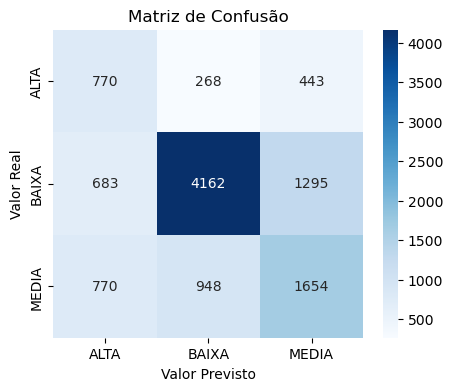

In [24]:
# Plotando a matriz de confusão como heatmap
labels = ['ALTA', 'BAIXA', 'MEDIA']
plot_confusion_matrix(y_test_bert, prediction, labels)